In [65]:
import os
import zipfile

def unzip_files_in_root():
    # Meghatározzuk a gyökérkönyvtárat (ahol a script/notebook fut)
    root_directory = os.getcwd()

    # Végigmegyünk az összes fájlon a gyökérkönyvtárban
    for file_name in os.listdir(root_directory):
        file_path = os.path.join(root_directory, file_name)

        # Csak .zip fájlokat csomagolunk ki
        if os.path.isfile(file_path) and file_name.endswith('.zip'):
            # Létrehozzuk a kicsomagolási célmappát a zip fájl neve alapján (kiterjesztés nélkül)
            extract_folder_name = os.path.splitext(file_name)[0]
            extract_path = os.path.join(root_directory, extract_folder_name)

            # Kicsomagoljuk a zip fájlt a megadott mappába
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"'{file_name}' sikeresen kicsomagolva '{extract_folder_name}' mappába.")

    print("Az összes zip fájl kicsomagolása befejeződött.")

# Használat
#unzip_files_in_root()


In [66]:
import os

def delete_zip_files_in_root():
    # Meghatározzuk a gyökérkönyvtárat (ahol a script/notebook fut)
    root_directory = os.getcwd()

    # Végigmegyünk az összes fájlon a gyökérkönyvtárban
    for file_name in os.listdir(root_directory):
        file_path = os.path.join(root_directory, file_name)

        # Csak .zip fájlokat törlünk
        if os.path.isfile(file_path) and file_name.endswith('.zip'):
            try:
                os.remove(file_path)
                print(f"'{file_name}' sikeresen törölve.")
            except Exception as e:
                print(f"Hiba történt '{file_name}' törlésekor: {e}")

    print("Az összes zip fájl törlése befejeződött.")

# Használat
#delete_zip_files_in_root()


In [1]:
import tensorflow as tf
import pandas as pd
from keras import layers, Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.api.applications.vgg19 import VGG19
from keras.api.applications.vgg19 import preprocess_input, decode_predictions
from keras.api.layers import Dense, Flatten, Dropout, Activation,GlobalAveragePooling2D,Lambda, RandomRotation, RandomZoom, RandomFlip, RandomTranslation

# 1. Adatok előkészítése
# CSV betöltése
data_dir_train = "./train_data"  # A képek könyvtára
labels_train_df = pd.read_csv("./encoded_species_train.csv", sep=';',encoding="utf-8")  # Címkék CSV fájl
data_dir_valid = "./valid_data"
labels_valid_df = pd.read_csv("./encoded_species_valid.csv", sep=',',encoding="utf-8")  # Címkék CSV fájl

labels_train_df['poisonous'].value_counts()
labels_valid_df['poisonous'].value_counts()


poisonous
0    6218
1     190
Name: count, dtype: int64

In [2]:
labels_train_df['poisonous'].value_counts()

poisonous
0    35706
1     1137
Name: count, dtype: int64

In [3]:
labels_train_df

,image_path,species_encoded,poisonous
0,2238546328-30620.JPG,82,0
1,2558871973-53941.JPG,43,0
2,2238503501-245559.JPG,31,0
3,2446759075-197643.JPG,53,0
4,2238472345-167057.JPG,85,0
...,...,...,...
36838,2446757906-271276.JPG,11,0
36839,2383042711-265797.JPG,76,0
36840,2868483523-65487.JPG,49,0
36841,2864909440-212519.JPG,74,0


In [4]:
labels_valid_df

,image_path,species_encoded,poisonous
0,0-3008834345.JPG,32,0
1,1-3008834345.JPG,32,0
2,0-3008834364.JPG,54,0
3,1-3008834364.JPG,54,0
4,2-3008834364.JPG,54,0
...,...,...,...
6403,4-3024144356.JPG,63,0
6404,0-3024144386.JPG,24,0
6405,1-3024144386.JPG,24,0
6406,2-3024144386.JPG,24,0


labels_df.loc[labels_df['species_encoded'].between(1, 20), 'poisonous'] = 1

labels_df['poisonous'].value_counts()

In [5]:
from keras.api.models import Model, Sequential
from keras import layers
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
# Címkék és file path-ek betöltése
file_paths_train = [f"{data_dir_train}/{fname}" for fname in labels_train_df["image_path"]]
species_labels_train = labels_train_df["species_encoded"].values  # Többosztályos címkék
toxicity_labels_train = labels_train_df["poisonous"].values  # Bináris címkék

file_paths_valid = [f"{data_dir_valid}/{fname}" for fname in labels_valid_df["image_path"]]
species_labels_valid = labels_valid_df["species_encoded"].values  # Többosztályos címkék
toxicity_labels_valid = labels_valid_df["poisonous"].values  # Bináris címkék


In [7]:
# Egyéni adatbetöltő függvény
def preprocess_image(filename, species_label, toxicity_label):
    # Kép betöltése és átméretezése
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (130, 130))
    return image, {"species": species_label, "toxicity": toxicity_label}

# TensorFlow dataset létrehozása
file_paths_ds = tf.data.Dataset.from_tensor_slices((file_paths_train, species_labels_train, toxicity_labels_train))
dataset = file_paths_ds.map(preprocess_image)

# Adat split (train és validation)
train_size = int(len(file_paths_train))
train_dataset = dataset.take(train_size).batch(8)

print(len(train_dataset))

file_paths_ds = tf.data.Dataset.from_tensor_slices((file_paths_valid, species_labels_valid, toxicity_labels_valid))
dataset = file_paths_ds.map(preprocess_image)

# Adat split (train és validation)
valid_size = int(len(file_paths_valid))
valid_dataset = dataset.take(valid_size).batch(8)

print(len(valid_dataset))

4606
801


In [13]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)



In [9]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(130, 130, 3))

for layer in base_model.layers:
     layer.trainable = False

import tensorflow as tf
from tensorflow.keras import backend as K

def f1_macro(y_true, y_pred):
    # Convert predictions to class indices if needed
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int64)

    # Get the number of classes dynamically
    num_classes = tf.reduce_max(y_true) + 1

    # Initialize a tensor to store F1 scores for each class
    f1_scores = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)

    # Use tf.range instead of Python's range
    for i in tf.range(num_classes):
        # Calculate precision and recall for class i
        true_positive = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, i), tf.equal(y_true, i)), tf.float32))
        predicted_positive = tf.reduce_sum(tf.cast(tf.equal(y_pred, i), tf.float32))
        actual_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, i), tf.float32))

        precision = true_positive / (predicted_positive + K.epsilon())
        recall = true_positive / (actual_positive + K.epsilon())

        # Calculate F1 score for the class
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        f1_scores = f1_scores.write(i, f1)

    # Stack F1 scores and compute their mean (macro F1)
    macro_f1 = tf.reduce_mean(f1_scores.stack())
    return macro_f1


In [10]:
from keras.metrics import Precision, Recall
from keras import backend as K

# Initialize Precision and Recall for F1 calculation
precision = Precision()
recall = Recall()

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + K.epsilon())


In [11]:


# Define the confusion costs
c_PSC = tf.constant(100.0, dtype=tf.float32)  # Cost for poisonous species confusion
c_ESC = tf.constant(1.0, dtype=tf.float32)    # Cost for edible species confusion

# Classification loss for species
def species_loss(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

# Custom loss for toxicity with confusion cost
def toxicity_confusion_loss(y_true, y_pred):
    # `y_true` and `y_pred` are binary (0 = edible, 1 = poisonous)
    confusion_cost = tf.where(
        tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 0)),  # poisonous misclassified as edible
        c_PSC,
        tf.where(
            tf.logical_and(tf.equal(y_true, 0), tf.equal(tf.round(y_pred), 1)),  # edible misclassified as poisonous
            c_ESC,
            tf.constant(0.0, dtype=tf.float32)
        )
    )
    # Binary cross-entropy for toxicity classification + confusion cost
    base_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return base_loss + confusion_cost


In [14]:
# 2. Modell felépítése
def build_multitask_model(input_shape):

    data_augmentation = Sequential([
    RandomRotation(0.2),       # Forgatás ±20%-kal
    RandomFlip("horizontal"),  # Vízszintes tükrözés
    ])

    x = data_augmentation(base_model.input)
    x = base_model(inputs=x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Faj osztályozó fej
    species_head = Dense(1024, activation='relu')(x)
    species_head = Dropout(0.25)(species_head)
    species_head = Dense(1024, activation='relu')(species_head)
    species_output = layers.Dense(100, activation="softmax", name="species")(species_head)

    # Mérgezőség osztályozó fej
    toxicity_head = Dense(1024, activation='relu')(x)
    toxicity_head = Dropout(0.25)(toxicity_head)
    toxicity_head = layers.Dense(1024, activation="relu")(toxicity_head)
    toxicity_output = layers.Dense(1, activation="sigmoid", name="toxicity")(toxicity_head)

    model = Model(inputs=base_model.input, outputs=[species_output, toxicity_output])
    return model

input_shape = (130, 130, 3)
model = build_multitask_model(input_shape)

# 3. Modell összeállítása
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.000175),
    loss={
        "species": "sparse_categorical_crossentropy",
        "toxicity": toxicity_confusion_loss
    },
    metrics={
        "species": "accuracy",
        "toxicity": f1_score
    }
)
# 4. Modell tanítása
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [early_stopping],
    epochs=100
)


Epoch 1/100
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 1636s 355ms/step - loss: 7.1411 - species_accuracy: 0.1529 - species_loss: 3.7633 - toxicity_f1_score: 0.0211 - toxicity_loss: 3.3778 - val_loss: 5.6696 - val_species_accuracy: 0.3335 - val_species_loss: 2.6139 - val_toxicity_f1_score: 0.0177 - val_toxicity_loss: 3.0557
Epoch 2/100
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 1623s 352ms/step - loss: 6.1211 - species_accuracy: 0.2896 - species_loss: 2.8018 - toxicity_f1_score: 0.0180 - toxicity_loss: 3.3193 - val_loss: 5.5262 - val_species_accuracy: 0.3688 - val_species_loss: 2.4757 - val_toxicity_f1_score: 0.0198 - val_toxicity_loss: 3.0505
Epoch 3/100
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 1620s 352ms/step - loss: 5.8649 - species_accuracy: 0.3326 - species_loss: 2.5774 - toxicity_f1_score: 0.0203 - toxicity_loss: 3.2875 - val_loss: 5.3538 - val_species_accuracy: 0.3883 - val_species_loss: 2.3761 - val_toxicity_f1_score: 0.0238 - val_toxicity_loss: 2.9777
Epoch 4/100
4606/4606 ━━━━━━━━━━━━━━━━━━━━ 1650s 358ms/ste

Minimum validation loss: 5.134632110595703


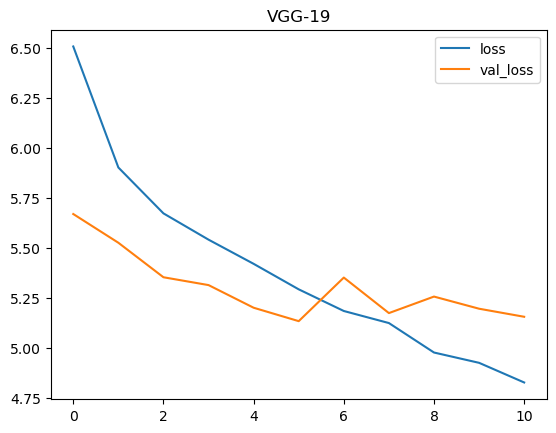

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
plt.title("VGG-19")
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))